In [13]:
import sys
sys.path.append("../")
import engarde.decorators as ed


import os
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from functools import reduce
from patsy import dmatrices
import statsmodels.formula.api as smf

from library import test

In [14]:
@ed.verify(test.allyearsandtpsd)
def load(data):
    return data

In [31]:
data_path = '/Users/kylieleblancKylie/domino/dofis/data/'
table_path = '/Users/kylieleblancKylie/domino/dofis/results/descriptive/'
data = pd.read_csv(os.path.join(data_path, 'clean', 'cits.csv'),
                  sep=",", low_memory=False)
data = load(data)
data.head()
data = data[['distname', 'doi', 'district', 'treat', 'year','doi_year', 'post', 'year_centered', 'students_hisp', 'type_rural', 'type_suburban', 'type_urban', 'students_num', 'avescores']]
data.reset_index().tail(10)

,index,distname,doi,district,treat,year,doi_year,post,year_centered,students_hisp,type_rural,type_suburban,type_urban,students_num,avescores
7164,7164,ALBA-GOLDEN ISD,False,250906,0,2018,NaN,1.0,2.0,0.095130,0,0,0,883,0.290354
7165,7165,WINNSBORO ISD,True,250907,1,2018,2018.0,1.0,0.0,0.168532,0,0,0,1519,0.820199
7166,7166,DENVER CITY ISD,True,251901,1,2018,2017.0,1.0,1.0,0.823145,0,0,0,1685,0.086865
7167,7167,PLAINS ISD,False,251902,0,2018,NaN,1.0,2.0,0.684564,1,0,0,447,-0.407764
7168,7168,GRAHAM ISD,True,252901,1,2018,2017.0,1.0,1.0,0.301541,0,0,0,2401,0.306810
7169,7169,NEWCASTLE ISD,True,252902,1,2018,2017.0,1.0,1.0,0.164502,1,0,0,231,0.736085
7170,7170,OLNEY ISD,True,252903,1,2018,2017.0,1.0,1.0,0.384615,1,0,0,676,0.897267
7171,7171,ZAPATA COUNTY ISD,True,253901,1,2018,2017.0,1.0,1.0,0.991155,0,1,0,3505,-0.795776
7172,7172,CRYSTAL CITY ISD,False,254901,0,2018,NaN,1.0,2.0,0.981548,0,0,0,1951,-0.668939
7173,7173,LA PRYOR ISD,True,254902,1,2018,2018.0,1.0,0.0,0.952991,1,0,0,468,0.059318


In [16]:
df_dist = data[data.year == 2016][['district','doi', 'distname', 'treat', 'type_rural', 'type_suburban', 'type_urban']]
df_12 = data[data.year == 2012][['district',  'students_hisp', 'students_num', 'avescores']].rename(columns = {'students_hisp': 'hisp12', 'students_num': 'num12', 'avescores': 'scores12'})
df_13 = data[data.year == 2013][['district', 'students_hisp', 'students_num', 'avescores']].rename(columns = {'students_hisp': 'hisp13', 'students_num': 'num13', 'avescores': 'scores13'})
df_14 = data[data.year == 2014][['district', 'students_hisp', 'students_num', 'avescores']].rename(columns = {'students_hisp': 'hisp14', 'students_num': 'num14', 'avescores': 'scores14'})
df_15 = data[data.year == 2015][['district', 'students_hisp', 'students_num', 'avescores']].rename(columns = {'students_hisp': 'hisp15', 'students_num': 'num15', 'avescores': 'scores15'})
df = reduce(lambda x, y: pd.merge(x, y, how = 'inner', on = ['district']), [df_dist, df_12, df_13, df_14, df_15])
df.tail()

,district,doi,distname,treat,type_rural,type_suburban,type_urban,hisp12,num12,scores12,hisp13,num13,scores13,hisp14,num14,scores14,hisp15,num15,scores15
1019,252902,True,NEWCASTLE ISD,1,1,0,0,0.095745,188,0.684344,0.128205,195,0.560117,0.132701,211,0.714516,0.100000,210,0.540722
1020,252903,True,OLNEY ISD,1,1,0,0,0.369681,752,0.178265,0.372654,746,0.133568,0.362117,718,0.224508,0.365517,725,0.644250
1021,253901,True,ZAPATA COUNTY ISD,1,0,1,0,0.990449,3455,-0.864683,0.988842,3585,-0.835494,0.991101,3596,-1.026554,0.989937,3677,-1.110470
1022,254901,False,CRYSTAL CITY ISD,0,0,0,0,0.980372,1987,-1.601103,0.983936,1992,-1.575632,0.979622,2012,-1.524065,0.978120,2011,-1.388884
1023,254902,True,LA PRYOR ISD,1,1,0,0,0.944325,467,-1.246076,0.941788,481,-1.198154,0.928571,476,-1.210100,0.939959,483,-0.970756


# Propensity Scores without test scores

In [17]:
y, X = dmatrices('treat ~ type_rural + type_suburban + type_urban + hisp12 + hisp13 + hisp14 + hisp15 + num12 + num13 + num14 + num15',
                 data=df, return_type='dataframe', NA_action = "drop")
mod = smf.Logit(y, X)    # Describe model
res = mod.fit()       # Fit model
print(res.summary())   # Summarize model
df['ps1'] = res.predict(X)

Optimization terminated successfully.
         Current function value: 0.453403
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                 1024
Model:                          Logit   Df Residuals:                     1012
Method:                           MLE   Df Model:                           11
Date:                Tue, 21 May 2019   Pseudo R-squ.:                 0.08187
Time:                        14:44:29   Log-Likelihood:                -464.28
converged:                       True   LL-Null:                       -505.69
                                        LLR p-value:                 4.220e-13
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.5554      0.228     11.193      0.000       2.108       3.003
type_rural       -0.

## Plot Overlap

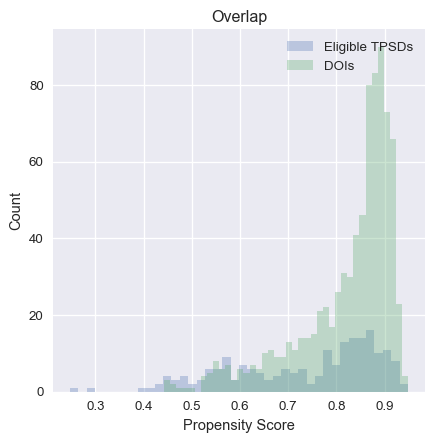

In [18]:
plt.style.use('seaborn')
my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)


kwargs = dict(histtype='stepfilled', alpha=0.3, bins=40)
plt.hist(df[(df.treat == 0) & (pd.notnull(df.ps1))].ps1, **kwargs, label = "Eligible TPSDs")
plt.hist(df[(df.treat == 1) & (pd.notnull(df.ps1))].ps1, **kwargs, label = "DOIs")

plt.legend()


plt.xlabel('Propensity Score')
plt.title('Overlap')
plt.ylabel('Count')
plt.show()


## Weight

In [19]:
df['psweight1'] = np.where((df.treat == True), 1/df.ps1, 1/(1-df.ps1))
sum(df.psweight1)

2065.9057339130036

## Trim
No one observation weighted more than 4%

In [20]:
total_weight_TPSD = sum(df[(df.treat == 0) & (pd.notnull(df.ps1))].psweight1)
total_weight_DOI = sum(df[(df.treat == 1) & (pd.notnull(df.ps1))].psweight1)
df['pswtshare1'] = np.where(df.treat == 1, ((df.psweight1/total_weight_DOI)*100), (df.psweight1/total_weight_TPSD*100))
print(sum(df.pswtshare1))
df[df.pswtshare1 > 4]

199.99999999999994


,district,doi,distname,treat,type_rural,type_suburban,type_urban,hisp12,num12,scores12,...,scores13,hisp14,num14,scores14,hisp15,num15,scores15,ps1,psweight1,pswtshare1


# With Test Scores

In [21]:
y, X = dmatrices('treat ~ type_rural + type_suburban + type_urban + hisp12 + hisp13 + hisp14 + hisp15 + num12 + num13 + num14 + num15 + scores12 + scores13 + scores14 + scores15',
                 data=df, return_type='dataframe', NA_action = "drop")
mod = smf.Logit(y, X)    # Describe model
res = mod.fit()       # Fit model
print(res.summary())   # Summarize model
df['ps2'] = res.predict(X)

Optimization terminated successfully.
         Current function value: 0.441864
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                 1019
Model:                          Logit   Df Residuals:                     1003
Method:                           MLE   Df Model:                           15
Date:                Tue, 21 May 2019   Pseudo R-squ.:                  0.1001
Time:                        14:44:58   Log-Likelihood:                -450.26
converged:                       True   LL-Null:                       -500.34
                                        LLR p-value:                 1.215e-14
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.4021      0.242      9.936      0.000       1.928       2.876
type_rural       -0.

## Weights

In [22]:
df['psweight2'] = np.where((df.treat == True), 1/df.ps2, 1/(1-df.ps2))

total_weight_TPSD = sum(df[(df.treat == 0) & (pd.notnull(df.ps2))].psweight2)
total_weight_DOI = sum(df[(df.treat == 1) & (pd.notnull(df.ps2))].psweight2)
df['pswtshare2'] = np.where(df.treat == 1, ((df.psweight2/total_weight_DOI)*100), (df.psweight2/total_weight_TPSD*100))
sum(df[pd.notnull(df.pswtshare2)].pswtshare2)

200.00000000000017

# Trim

In [23]:
total_weight_TPSD = sum(df[(df.treat == 0) & (pd.notnull(df.ps2))].psweight2)
total_weight_DOI = sum(df[(df.treat == 1) & (pd.notnull(df.ps2))].psweight2)
df['pswtshare2'] = np.where(df.treat == 1, ((df.psweight2/total_weight_DOI)*100), (df.psweight2/total_weight_TPSD*100))
print(sum(df.pswtshare1))
df[df.pswtshare1 > 4]

199.99999999999994


,district,doi,distname,treat,type_rural,type_suburban,type_urban,hisp12,num12,scores12,...,scores14,hisp15,num15,scores15,ps1,psweight1,pswtshare1,ps2,psweight2,pswtshare2


# Merge PS Weight

In [24]:
ps = df[['district', 'hisp12', 'hisp13', 'hisp14', 'hisp15', 
         'num12', 'num13', 'num14', 'num15',
         'scores12', 'scores13', 'scores14','scores15',
         'ps1', 'psweight1', 'pswtshare1',
        'ps2', 'psweight2', 'pswtshare2']]
data = pd.read_csv(os.path.join(data_path, 'clean', 'cits.csv'),
                  sep=",", low_memory=False)
cits_match = data.merge(ps, how = 'left', on = 'district')
cits_match.to_csv(os.path.join(data_path, 'clean', 'cits_match.csv'), sep=",")
load(cits_match)
cits_match.head()

,Unnamed: 0,district,distname,year,cntyname,distischarter,rating_academic,rating_financial,eligible,type,...,scores12,scores13,scores14,scores15,ps1,psweight1,pswtshare1,ps2,psweight2,pswtshare2
0,0,1902,CAYUGA ISD,2012,ANDERSON,N,NaN,NaN,NaN,H,...,0.353060,0.594987,0.592886,0.645039,0.891787,1.121344,0.109808,0.910373,1.098451,0.107971
1,1,1903,ELKHART ISD,2012,ANDERSON,N,NaN,NaN,NaN,G,...,-0.035835,0.096707,0.303144,0.459442,0.918142,1.089157,0.106656,0.918841,1.088327,0.106976
2,2,1904,FRANKSTON ISD,2012,ANDERSON,N,NaN,NaN,NaN,H,...,-0.111224,0.212638,0.291718,0.478320,0.870107,1.149283,0.112544,0.871492,1.147457,0.112788
3,3,1906,NECHES ISD,2012,ANDERSON,N,NaN,NaN,NaN,H,...,0.756389,0.881751,0.924896,0.178017,0.878874,1.137820,0.111421,0.930691,1.074471,0.105614
4,4,1907,PALESTINE ISD,2012,ANDERSON,N,NaN,NaN,NaN,E,...,-0.573327,-0.490031,-0.408097,-0.321485,0.843056,1.186161,0.116155,0.814496,1.227753,0.120680
